## **Sistem Pengenalan dan Interpretasi Bahasa Isyarat dengan Faster R-CNN**


###**Blok Diagram**

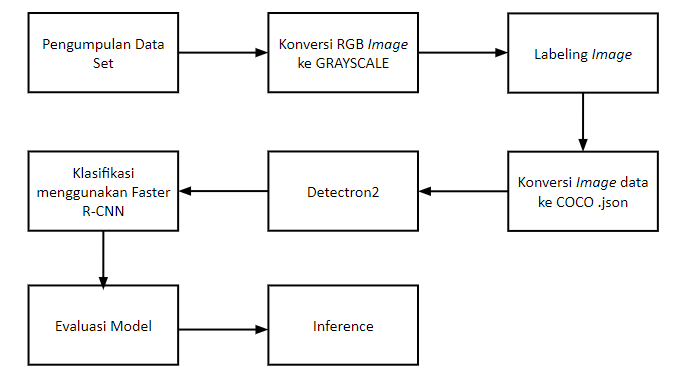

#### **Pengumpulan Dataset**

Dataset diambil dari Kaggle (https://www.kaggle.com/grassknoted/asl-alphabet) berformat RGB. Dataset memiliki 26 kelas dengan 2000 data. Namun kali ini kami baru akan menggunakan 4 kelas (A B C D E) dengan 400 sample data di setiap kelasnya.

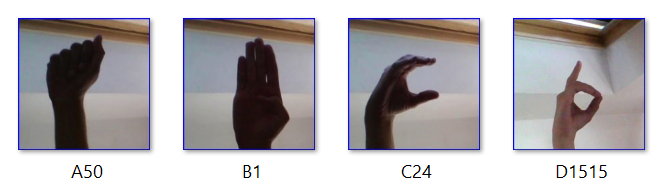

#### **Konversi RGB Image ke GRAYSCALE**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Import the libraries
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Dataset/A (257).zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

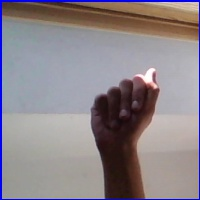

In [ ]:
baca_img = cv2.imread('/tmp/A (257).jpg')
cv2_imshow(baca_img)

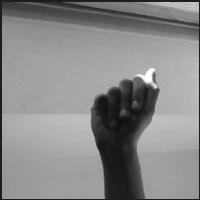

In [ ]:
baca_img = cv2.imread('/tmp/A (257).jpg')
gray_images = cv2.cvtColor(baca_img, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray_images)
#cv2.imwrite('D:/Semester 6/Komputasi Citra Digital/Bismillah/Dataset_gray/trainABCD/A/A%i.jpg' %i, gray_images)
cv2.waitKey(1500)
cv2.destroyAllWindows()

#### **Labelling Image**

Untuk labeling kelas dan anotasi dataset, kami menggunakan Roboflow.

https://app.roboflow.com/syifa-39-hukma/dataset_abcd_fix/2 

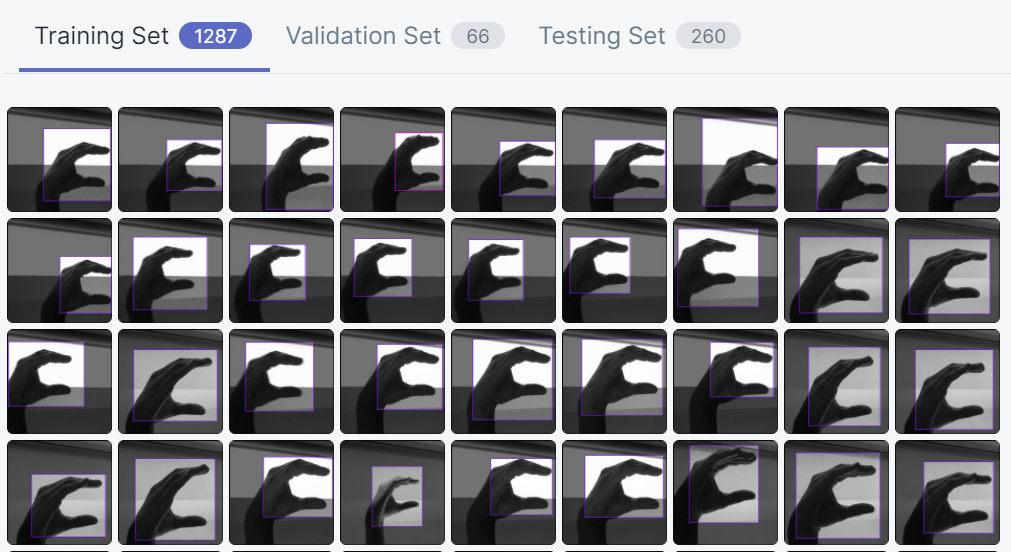

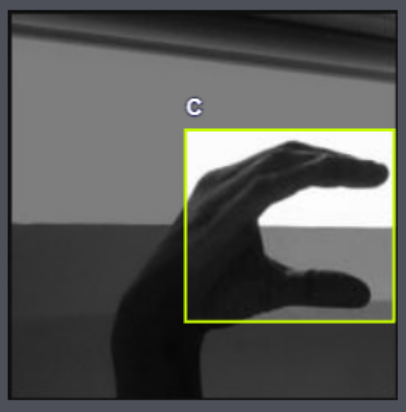

#### **Konversi Image ke COCO .json**

Setelah selesai melakukan anotasi dan labeling, dataset disimpan dalam format json COCO. COCO format terdiri atas JSON file termasuk semua detail pada gambar seperti size, annotation (bounding box, koordinat), dan label objek yang ada pada bounding box.

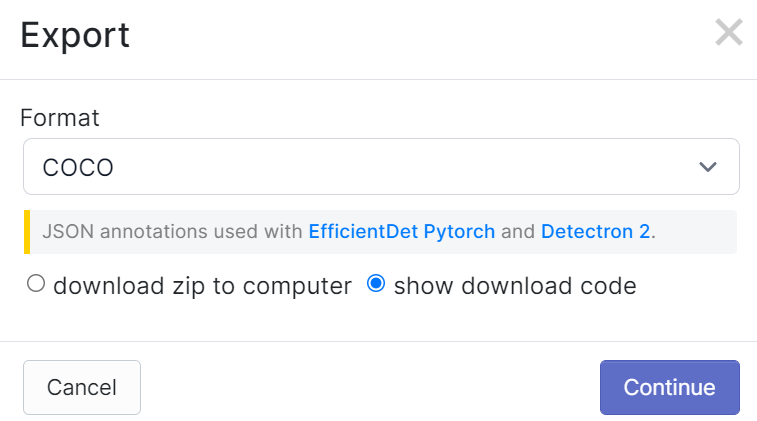

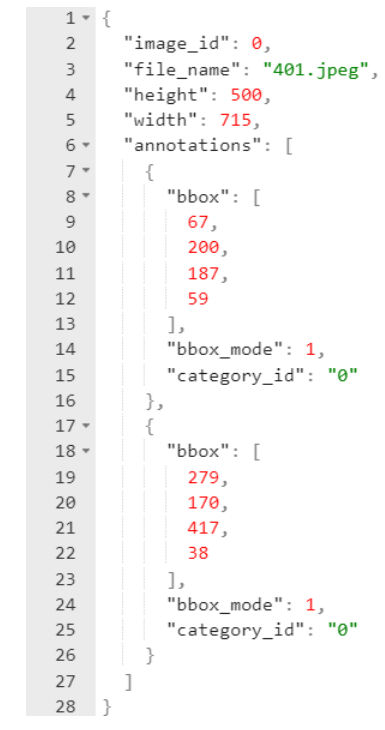

#### **Detectron2**

Detectron2 merupakan library open source research oleh Facebook AI untuk objek detection.

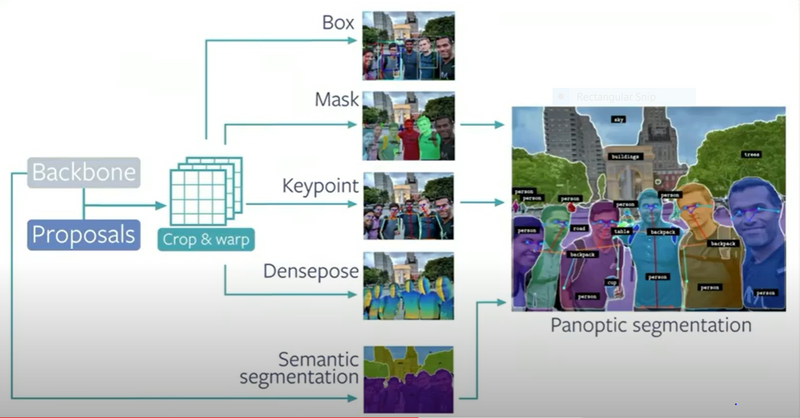

#### **Klasifikasi Menggunakan Faster RCNN**

#### **Evaluasi Model**

#### **Inference**

## **1. Install Detectron2 Dependencies**

### **Install Pytorch**

In [ ]:
# install dependencies Pytorch

!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html       
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

import torch, torchvision

print(torch.__version__, torch.cuda.is_available())
!gcc --version

# opencv sudah pre-installed pada colab

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-us7k7xdj
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-us7k7xdj
1.5.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



### **Install Detectron2**

In [ ]:
# install detectron2
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html


### **Basic Setup**

In [ ]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog

## **2. Import Dataset**

Import dataset dari Roboflow yang telah berfomar JSON COCO menggunakan cURL lalu unzip dataset.

In [ ]:
!curl -L "{https://app.roboflow.com/ds/EICONnVVLy?key=MoSNT8PFZG}" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   887  100   887    0     0   2025      0 --:--:-- --:--:-- --:--:--  2025
100 8913k  100 8913k    0     0  14.8M      0 --:--:-- --:--:-- --:--:-- 14.8M
Archive:  roboflow.zip
replace README.dataset.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Register dataset pada folder dataset_train_sign, dataset_val_sign, dan dataset_test_sign

In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("dataset_train_sign", {}, "/content/train/_annotations.coco.json", "/content/train")
register_coco_instances("dataset_val_sign", {}, "/content/valid/_annotations.coco.json", "/content/valid")
register_coco_instances("dataset_test_sign", {}, "/content/test/_annotations.coco.json", "/content/test")

Visualisasikan  sample data training untuk melihat apakah dataset sudah sesuai

In [ ]:
#visualize training data
my_dataset_train_metadata = MetadataCatalog.get("dataset_train_sign")
dataset_dicts = DatasetCatalog.get("dataset_train_sign")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

## **3. Training data dengan Faster RCNN**

Pada tahap ini kita perlu mengkonfigurasikan model untuk ditraining. Secara teknis tidak banyak konfigurasi yang perlu dilakukan karena model sudah pre-trained pada COCO dataset.

Pada Detectron2, kita menggunakan model zoo untuk melakukan training yang dapat dilihat pada https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md#coco-object-detection-baselines 

Kali ini kami akan menggunakan model faster_rcnn_R_50_FPN_3x yang arsitekturnya terlihat pada gambar berikut

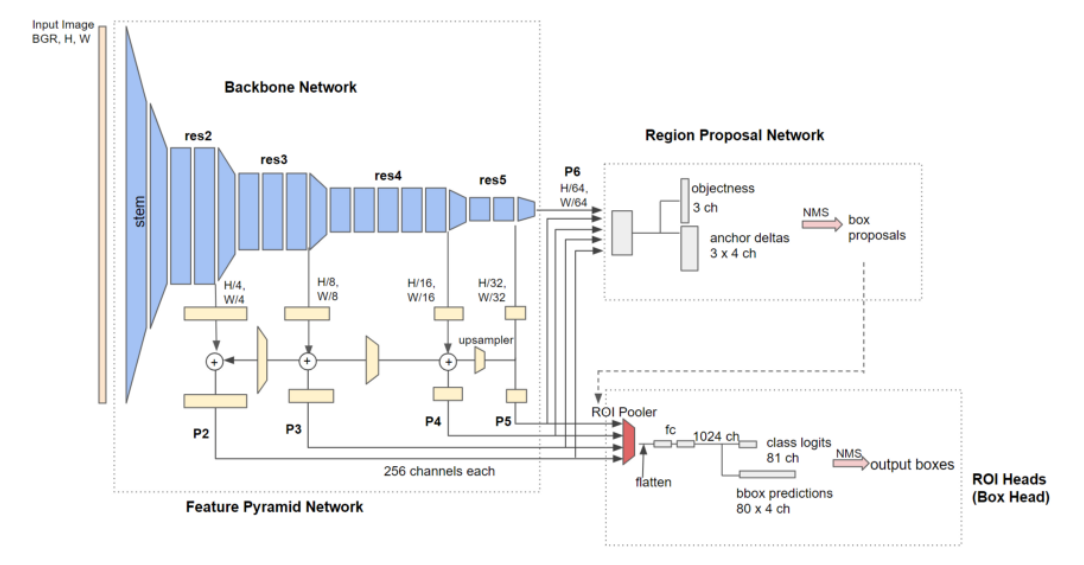

Terdapat backboned network (resnet) yang digunakan untuk mengekstrak fitur dari gambar diikuti dengan region proposal network untuk melakukan menentukan region proposal dan box head untuk bounding box. 

### **Import Trainer Module**

In [ ]:
#We are importing our own Trainer Module here to use the COCO validation evaluation during training. Otherwise no validation eval occurs.

from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

### **Import Model, Konfigurasi, dan Training**

In [ ]:
from detectron2 import model_zoo

In [ ]:
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("dataset_train_sign",)
cfg.DATASETS.TEST = ("dataset_val_sign",)

cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml") 
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001

cfg.SOLVER.WARMUP_ITERS = 100
cfg.SOLVER.MAX_ITER = 150 # adjust up jika val mAP (Mean Average Precision) masih naik dan adjust down jika sudah overvit
cfg.SOLVER.STEPS = (100, 150)
cfg.SOLVER.GAMMA = 0.05


cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5 

cfg.TEST.EVAL_PERIOD = 500


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

### **Kurva Training (Time, Accuracy, False Negative**)

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

### **Test Evaluation**

Umumnya model dievaluasi dengan COCO Standarts of Evaluation. Mean Average Precision (mAP) digunakan untuk menghitung performa model.

In [ ]:
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("dataset_test_sign", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "dataset_test_sign")
inference_on_dataset(trainer.model, val_loader, evaluator)

Didapat Average Precision pada masing-masing kelas sebagai berikut 


*   A : 51.4
*   B : 51.9
*   C : 55.0
*   D : 60.5





## **4. Inference dengan Detectron2 Save Weight**



Cek output yang ada. Folder output ini menyimpan **final weight** dari model yang telah di training. Kita bisa menggunakan folder ini untuk melakukan inference model.

In [ ]:
%ls ./output/

In [ ]:
# gunakan final weight yang ada setelah training dataset selesai
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

# masukan test dataset
cfg.DATASETS.TEST = ("dataset_test_sign", )

# set testing threshold
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  

predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("dataset_test_sign")

Tampilkan output gambar

In [ ]:
from detectron2.utils.visualizer import ColorMode
import glob

for imageName in glob.glob('/content/test/*jpg'):
  im = cv2.imread(imageName)
  outputs = predictor(im)
  v = Visualizer(im[:, :, ::-1],
                metadata=test_metadata, 
                scale=0.8
                 )
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])


#**Resources**


*  Step by Step Detectron2 : https://towardsdatascience.com/object-detection-in-6-steps-using-detectron2-705b92575578
*   Faster RCNN : https://towardsdatascience.com/understanding-fast-r-cnn-and-faster-r-cnn-for-object-detection-adbb55653d97
*  mAP : https://tarangshah.com/blog/2018-01-27/what-is-map-understanding-the-statistic-of-choice-for-comparing-object-detection-models/
* https://www.kaggle.com/grassknoted/asl-alphabet
